<a href="https://colab.research.google.com/github/lokalov/lokalov_ML/blob/dataset/courses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Добавление библиотек

In [143]:
!pip install --upgrade matplotlib > None # need refresh enviroment after installation

In [144]:
#pip install numpy

In [145]:
#pip install pandas

In [146]:
import pandas as pd
import numpy as np


In [305]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
from sklearn.preprocessing import scale

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

%matplotlib inline

## Подготовка данных

In [148]:
path = 'https://github.com/lokalov/lokalov_ML/raw/main/datasetVAL.xlsx'
data = pd.read_excel(path, index_col='Unnamed: 0')

In [149]:
data.head()

,N,VOZR,GOD_POST,VREM_OB,COD_COURS,UROVEN,NAPR,UZNAL,VR_PUT,PROFROD,TEACHER,STAG
1,6561,13,2016,1,6,3,2,знакомые,32,инженер,150,0
2,6587,14,2016,8,13,3,4,интернет,15,инженер,140,1
3,6971,14,2016,8,13,3,4,интернет,5,заведующий,140,1
4,6984,16,2016,8,16,3,7,знакомые,33,преподаватель,7,13
5,7045,14,2016,8,11,2,5,знакомые,17,менеджер,144,0



*   N - идентификационный номер учащегося
*   VOZR - полных лет учащемуся
*   GOD_POST - год поступления на курс
*   VREM_OB - продолжительность обучения (в месяцах)Новый пункт
*   COD_COURS - код курса - коррелирует с относительной сложностью курса
*   UROVEN - степень специализации курса (1-2-3)
*   NAPR - код предметной области (напр. графика, web-дизайн и т.д)
*   UZNAL - источник информации о курсах
*   VR_PUT - примерное время на дорогу до курсов (мин)
*   PROFROD - профессия родителя (заказчика)
*   TEACHER - код преподавателя
*   STAG - стаж преподавателя (в годах на год поступления учащегося)








In [150]:
data.shape

(3759, 12)

In [151]:
data.dtypes

N             int64
VOZR          int64
GOD_POST      int64
VREM_OB       int64
COD_COURS     int64
UROVEN        int64
NAPR          int64
UZNAL        object
VR_PUT        int64
PROFROD      object
TEACHER       int64
STAG          int64
dtype: object

## Выбор целевого показателя

Целевой показатель - интервал обучения. Должен быть более одного года.  Предсказываем для поступившего, сколько он проучится лет


Агрегирование данных

Данные группируются по учащимся с целью получения датафрейма, позволяющего проанализировать целевой показатель - интервал обучения (INT) - разница между годом записи на последний курс и годом записи на первый.

Можно предположить, что наиболее существенными параметрами, влияющими на целевой показатель будут:


1.   Возраст учащегося VOZR, first (чем младше учащийся, тем меньше в среднем от подготовлен, меньше специализирован)
2.   Уровень UROVEN и конкретный курс, на который пришел учащийся, его соответствие возрасту
3.   Преподаватель и опыт его работы (STAG). Важно учитывать как первого учителя (на первом курсае), который должен заитнересовать учащегося, так и последнего, который в принципе может быть причиной того, что учащийся покидает курсы



In [152]:
agg_func_selection = {'VR_PUT':['first'],'GOD_POST':['first','last'],'VOZR':['first'],'TEACHER': ['first', 'last'],'STAG': ['first', 'last'],'VREM_OB' : ['sum'], 'COD_COURS': ['first','last'], 'UROVEN': ['first','last']}

In [153]:
df=data.groupby(['N'], as_index= True).agg(agg_func_selection)

Убираем поступивших и закончивших в последнем году (в датасете не должно быть незавершенных интервалов обучения)

In [154]:
GOD_MAX=df['GOD_POST','last'].max()

In [155]:
 dfs=df.loc[(df['GOD_POST','first'] < GOD_MAX)&(df['GOD_POST','last']  < GOD_MAX)]


Заменяем абсолютные года на интервалы

In [156]:
INT = df.loc[:,('GOD_POST','last')]-df.loc[:,('GOD_POST','first')]

In [157]:
df['INT']=INT


Сбрасываем столбцы с конкретными годами поступлений на курсы и время обучения,  принципиально связанное с целевой функцией:

In [158]:
dfs=df.drop([('GOD_POST','last'),('GOD_POST','first'),('VREM_OB','sum')],axis=1)

dfs - датасет для разведывательного анализа

In [159]:
dfs.shape

(2036, 11)

## EDA (разведывательный анализ данных)

In [160]:
dfs.head()

VR_PUT  VOZR TEACHER       STAG      COD_COURS      UROVEN      INT
      first first   first last first last     first last  first last    
N                                                                       
6561     32    13     150  150     0    0         6    6      3    3   0
6587     15    14     140  140     1    1        13   13      3    3   0
6971      5    14     140  140     1    1        13   13      3    3   0
6984     33    16       7    7    13   13        16   16      3    3   0
7045     17    14     144  144     0    1        11   19      2    3   1

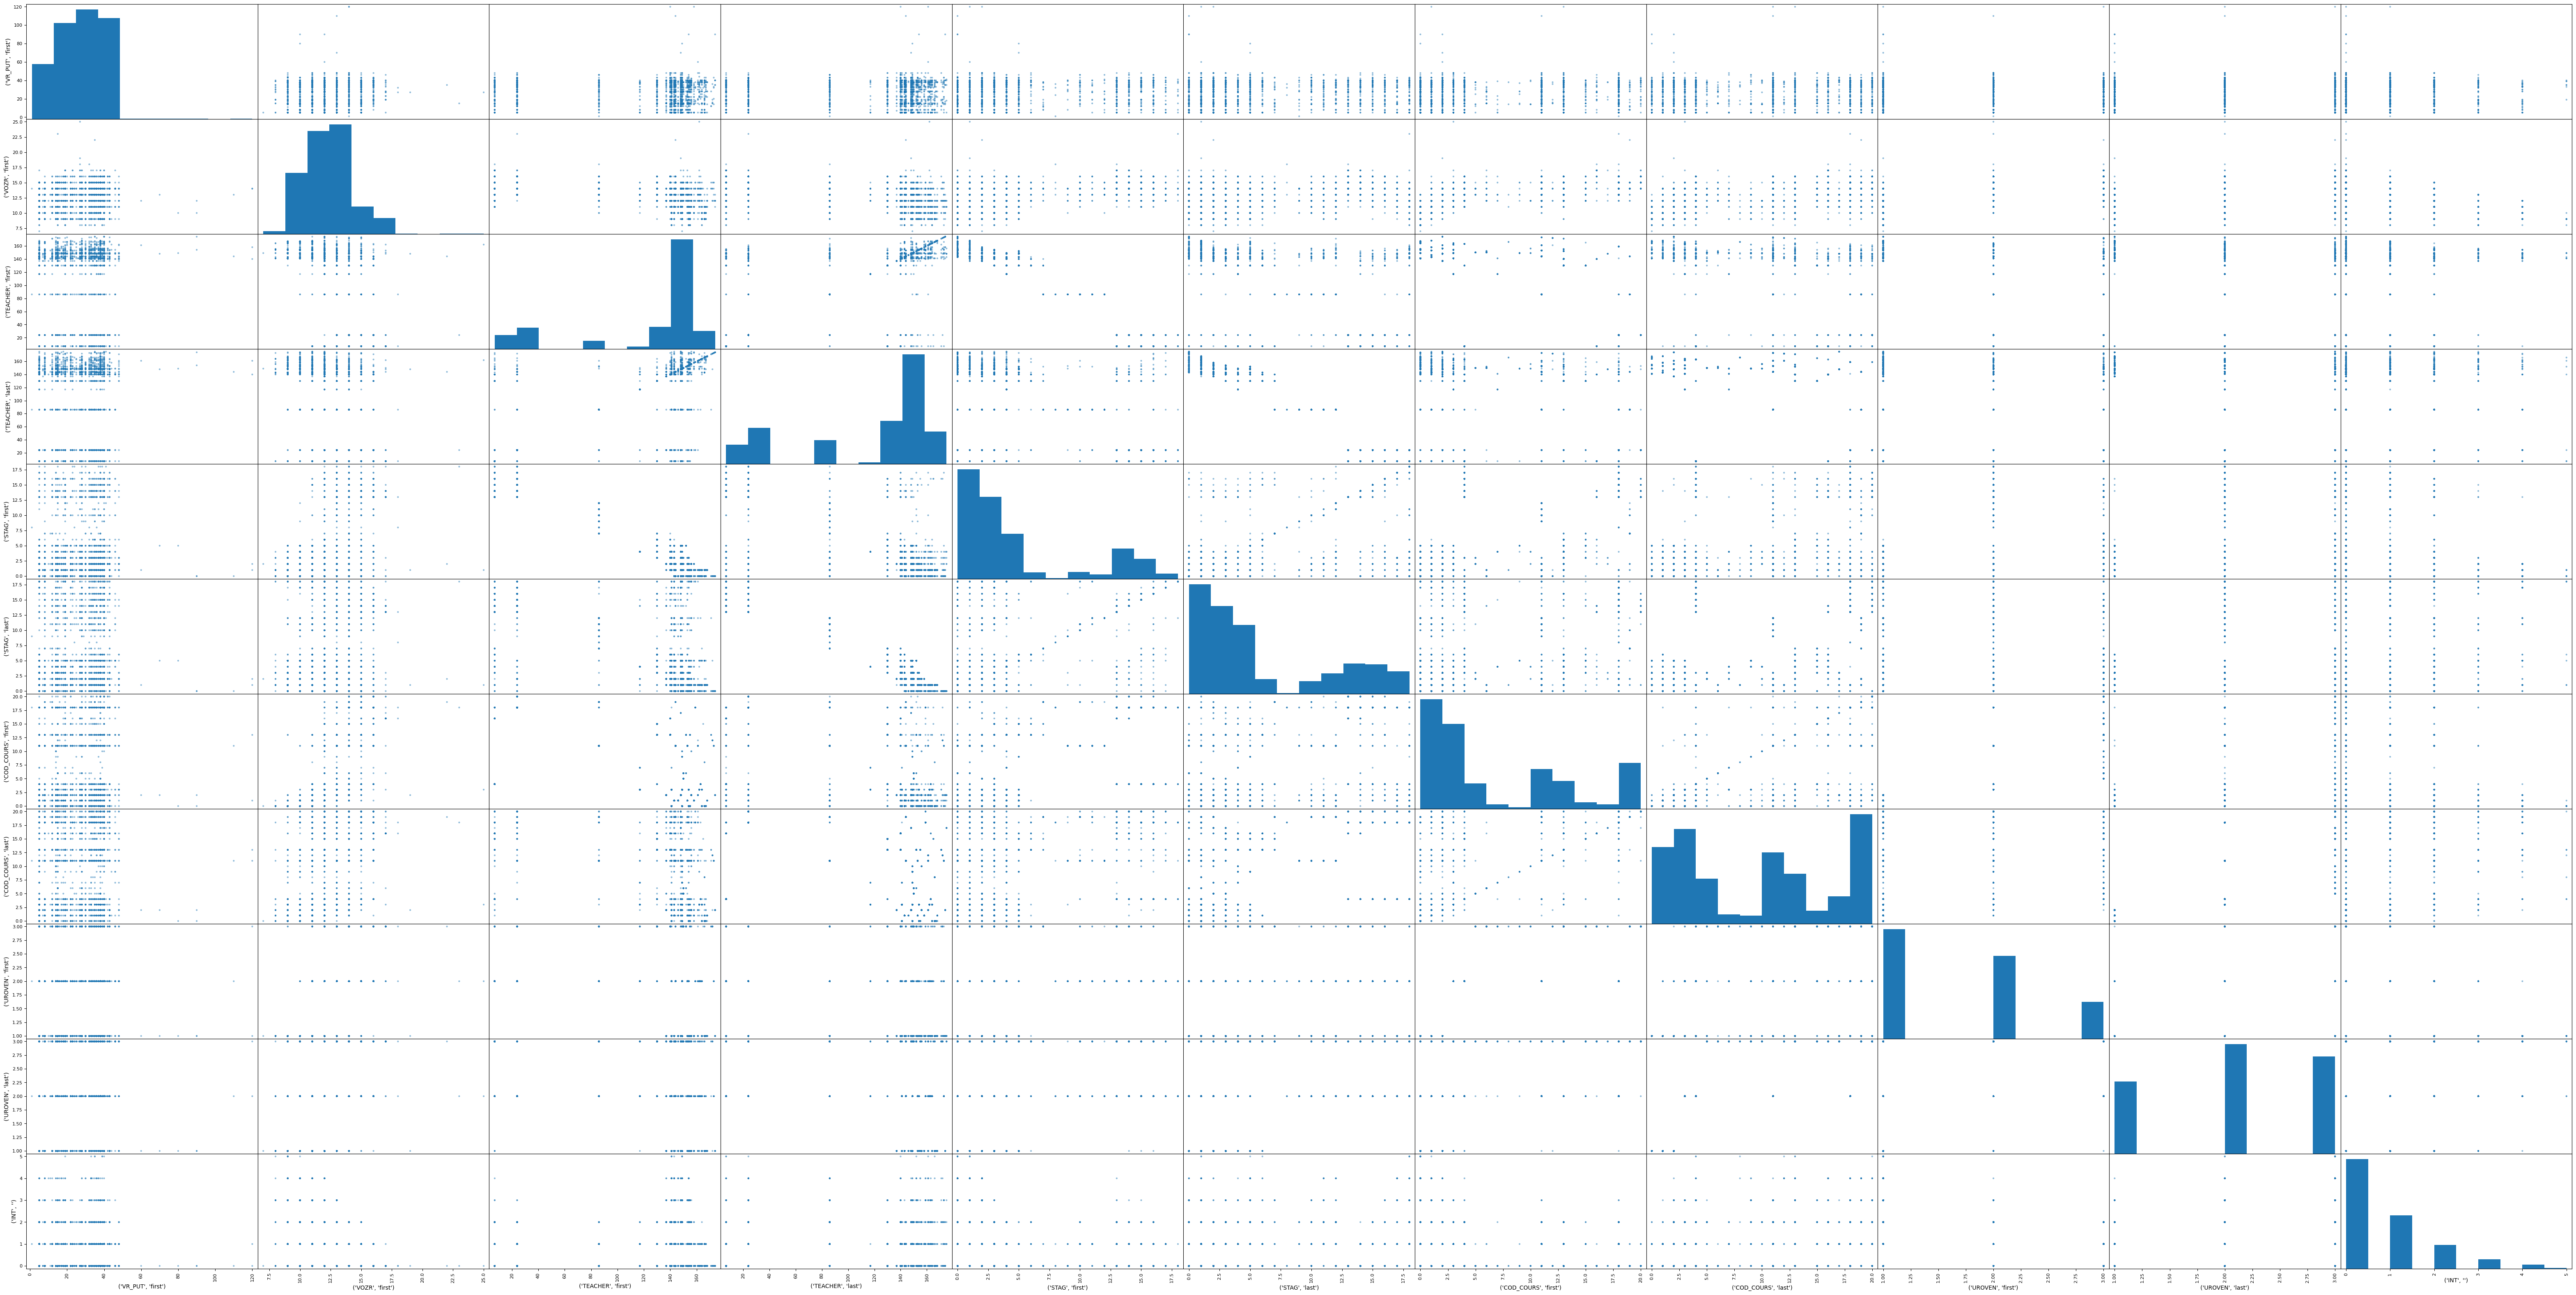

In [161]:
pd.plotting.scatter_matrix(dfs,figsize=(80,40));

In [162]:
dfs.dtypes

VR_PUT     first    int64
VOZR       first    int64
TEACHER    first    int64
           last     int64
STAG       first    int64
           last     int64
COD_COURS  first    int64
           last     int64
UROVEN     first    int64
           last     int64
INT                 int64
dtype: object

[Text(0.5, 80.5815972222222, ''), Text(95.58159722222221, 0.5, '')]

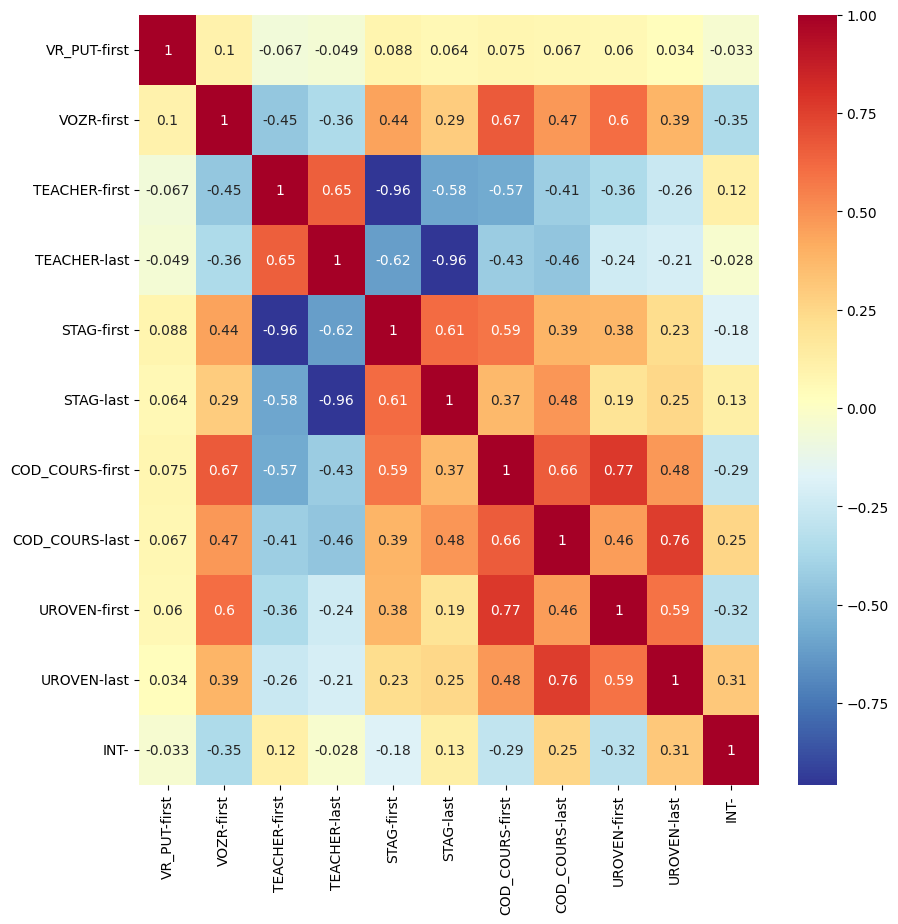

In [316]:
plt.figure(figsize=(10,10))
ax=sns.heatmap(dfs.corr(), annot=True, cmap="RdYlBu_r");
ax.set(xlabel="", ylabel="")


Тепловая карта показала ряд неочевидных корреляций. Их можно интерпретировать в контексте конкретной ситуации, которую надо исправлять.
Например, слабая отрицательная корреляция возраста поступления, уровня специализации первых курсов с интервалом обучения INT.
Положительная корреляция UROVEN-last COD_COURS-last говорит об том, что учащихся чаще задерживаются именно на специализированных курсах, со вводных чаще уходят.



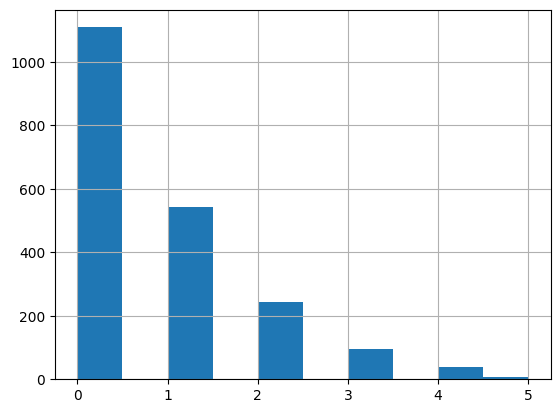

In [165]:
dfs['INT'].hist();



Гистограмма целевого показателя (распределение учащихся по количеству лет обучения).


# Выбор метрики. Выбор и тренировка бейзлайн модели

Разбиение датасета на тренировочную и тестовую часть.


In [317]:
y=dfs['INT']
X=dfs.drop([('VR_PUT','first'),('TEACHER','first'),('STAG','last'),'INT'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1030, test_size=0.25)

Примечание. В датасете оставлены столбцы, которые должны оказывать наиболее существенное влияние на целевой показатель.

In [318]:
print(y_train)

N
9324     1
10216    0
13251    0
13064    0
11740    2
        ..
12132    0
10710    1
12788    0
12721    0
12464    0
Name: INT, Length: 1527, dtype: int64


In [319]:
X_train.head()

VOZR TEACHER  STAG COD_COURS      UROVEN     
      first    last first     first last  first last
N                                                   
9324     12     141     0         1    3      1    2
10216    13     144     1        11   11      2    2
13251     9     143     5         1    1      1    1
13064    12     148     5         2    2      1    1
11740    11      86     4         0   11      1    2

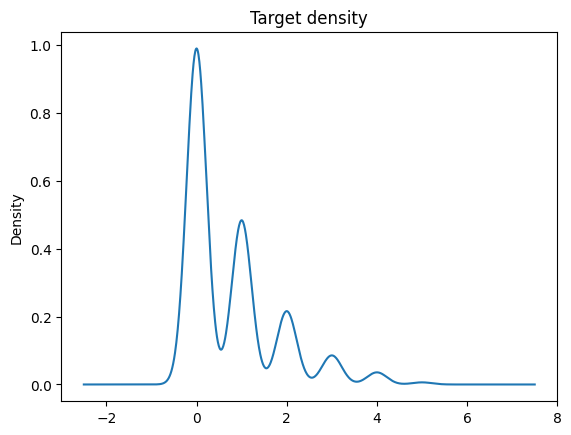

In [321]:
y.plot(kind='kde', title='Target density');

В качестве метрики выбрана - MSE - среднеквадратичная ошибка для линейной регрессии. Выбрана потому, что показывает чувствительна к большим ошибкам (за счет возведения в квадрат), что принципиально важно для разрабатываемой модели.

В качестве бейзлайн-модели выбрана модель линейной регресии.  Метрика и модель позволют достаточно легко интерпретировать полученный результат.




In [322]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
y_preds_dummy = dummy.predict(X_test)

In [323]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_test)

In [324]:
print(f'MSE for Dummy Regressor: {mean_squared_error(y_test, y_preds_dummy)}')
print(f'MSE for Linear regression: {mean_squared_error(y_test, y_preds_lr)}')

MSE for Dummy Regressor: 1.0763047506807177
MSE for Linear regression: 0.46570561660999926


Качество константного предсказания - 1.076 - низкое
Качество предсказание на отложенной выборке - средне-низкое, если учесть, что целевая функция принимает значения 0,1,2,..., а среднеквадратичное отклонение все-таки меньше, чем половина интервала.

In [299]:
def plot_model_results(actual, predicted, title):
  results = pd.DataFrame({'True': actual, 'Prediction': predicted})
  sns.lmplot(x='True', y='Prediction', data=results, fit_reg=False)
  d_line= np.arange(results.min().min(), results.max().max())
  plt.plot(d_line, d_line, color='red', linestyle='--')
  plt.title = title
  plt.grid()
  plt.show()

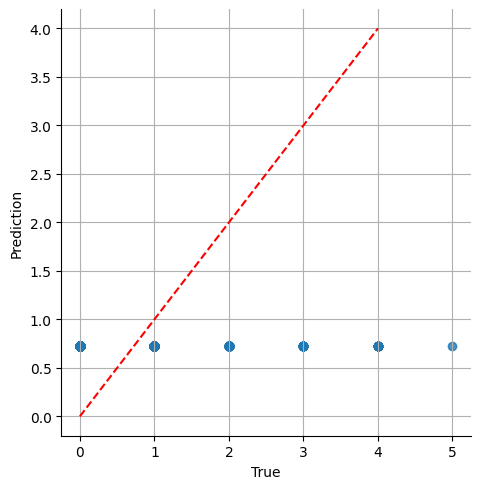

In [325]:
plot_model_results(y_test, y_preds_dummy, title='Dummy')

In [300]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_test)

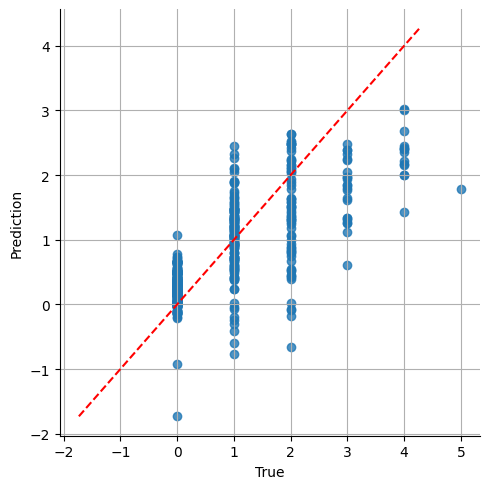

In [326]:
plot_model_results(y_test, y_preds_lr, title='Linear Regression')

In [302]:
print("Coefficients: \n", lr.coef_)

Coefficients: 
 [-0.15357061  0.00298996 -0.04218001  0.05849496 -0.52389267  0.60525301]


Для повышения качества модели предполагается использовать дерево решений